In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import pickle
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy import integrate, interpolate, stats
import pingouin as pg

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
%matplotlib notebook

In [5]:
sigalpha = 0.05

#### Functions

In [7]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='all'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [8]:
def get_zFR(trig_FR, FRtime):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
    baseline_avg = np.mean(trig_FR[FRtime < 0, :], axis=0)
    baseline_std = np.std(trig_FR[FRtime < 0, :], axis=0)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[:, nonzero_inds] = (trig_FR[:, nonzero_inds] - baseline_avg[None, nonzero_inds]) / baseline_std[None, nonzero_inds]
    
    return trig_Z

In [9]:
def p_stars(test_pval):
    if test_pval < 0.001:
        return '***'
    elif test_pval < 0.01:
        return '**'
    elif test_pval < 0.05:
        return '*'
    else:
        return 'n.s.'

#### Load metadata for experiments

In [10]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [11]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\psilocybin_exp'

### Load subjects

In [12]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\brain_states_subjects.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str}).astype({'analyze': bool})

In [13]:
subject_df.head()

,exp_type,mouse,experiment,sweep_states,stim_depth,bad_chs,analyze,data_loc,CCF_res,notes
0,psilocybin,657903,pilot_aw_psi_2023-01-13_12-18-22,"awake,psilocybin",deep,none,False,F:\psi_exp\mouse657903\pilot_aw_psi_2023-01-13...,25,"big lesion in CTX, stim closer to ORB anyway, ..."
1,psilocybin,666193,pilot_aw_psi_2023-02-16_10-55-48,psilocybin,deep,all,True,F:\psi_exp\mouse666193\pilot_aw_psi_2023-02-16...,25,no EEG
2,psilocybin,666194,pilot_aw_psi_2023-02-23_10-40-34,psilocybin,deep,none,True,F:\psi_exp\mouse666194\pilot_aw_psi_2023-02-23...,25,NaN
3,psilocybin,666196,pilot_aw_psi_2023-03-16_10-21-29,"awake,psilocybin,psilocybin,psilocybin,psilocy...",deep,all,True,F:\psi_exp\mouse666196\pilot_aw_psi_2023-03-16...,25,EEG bad?
4,psilocybin,669118,pilot_aw_psi_2023-03-24_09-55-33,"awake,psilocybin,psilocybin,psilocybin,psilocy...",deep,none,True,F:\psi_exp\mouse669118\pilot_aw_psi_2023-03-24...,25,"only has probe B, F"


## Get multi-subject metrics

In [14]:
call_saline_awake = False

skip_states = ['recovery']
psilocybin_window = 30 * 60 # min to include as "psilocybin" -> seconds; I tried 60 min on 5/10
substates = {'resting': True, 'running': False}
trial_threshold = 30 # must have more than this number of trials to be included in analysis
trial_max = 125 # limit some states that have many trials
unit_threshold = 25 # must have at least this number of units to be included in analysis, 5/10 was 5
time_bin = 0.0025 # size of time bins (s) for firing rate

test_window = [-2.0, 0.0] # this will look at baseline

In [15]:
all_subjects_states_info = []
all_subjects_data = {}
for indi, subrow in subject_df.iterrows():
    if not subrow.analyze:
        print('Skipping {} - {}, experiment excluded from analysis.\n'.format(subrow.mouse, subrow.exp_type))
        continue
#     elif subrow.bad_chs == 'all':
#         print('Skipping {} - {}, all EEG chs are bad.\n'.format(subrow.mouse, subrow.exp_type))
#         continue
    print('{}: {}'.format(subrow.mouse, subrow.experiment))
    if subrow.mouse in all_subjects_data.keys():
        all_subjects_data[subrow.mouse][subrow.exp_type] = {}
    else:
        all_subjects_data[subrow.mouse] = {}
        all_subjects_data[subrow.mouse][subrow.exp_type] = {}
    
    ## Load EEGexp and stim_log ##
    exp = EEGexp(subrow.data_loc, preprocess=False, make_stim_csv=False)
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
    
    ## Add baseline speed to stim_log ##
    event_running_file = os.path.join(exp.data_folder, 'evoked_data', 'event_running_speed.npy')
    event_running_ts_file = os.path.join(exp.data_folder, 'evoked_data', 'event_running_times.npy')
    event_running_signal = np.load(event_running_file)
    event_running_ts = np.load(event_running_ts_file)
    evinds = np.nonzero((event_running_ts >= test_window[0]) & (event_running_ts < test_window[1]))[0]
    mean_speed = np.mean(event_running_signal[evinds, :], axis=0)
    stim_log['BLspeed'] = mean_speed
    stim_log['BL_resting_trial'] = stim_log['BLspeed'] < 0.1

    ### Get all states in experiment ###
    all_sweeps = np.unique(stim_log['sweep'].values)

    ## Get state label for each sweep ##
    sweep_state_list = []
    for char in subrow.sweep_states.split(','):
        sweep_state_list.append(char)
    if len(sweep_state_list) == 1:
        sweep_state_list = sweep_state_list * len(all_sweeps)
    stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
    if call_saline_awake:
        stim_log['state'] = ['awake' if x == 'saline' else x for x in stim_log['state'].values]
    ## Get depth label for each sweep ##
    sweep_depth_list = []
    for char in subrow.stim_depth.split(','):
        sweep_depth_list.append(char)
    if len(sweep_depth_list) == 1:
        sweep_depth_list = sweep_depth_list * len(all_sweeps)
    stim_log['stim_depth'] = stim_log.apply(lambda x: sweep_depth_list[x.sweep], axis=1)
    ## Get list of states and the middle current ##
    states = np.unique(stim_log['state'].values)
    currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
    if len(currents) > 1:
        ch_curr = str(currents[1])
    else:
        ch_curr = str(currents[0])

    ## Load unit info ##
    fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
    if os.path.exists(fn_units_info):
        unit_info = pd.read_csv(fn_units_info)
        with open(os.path.join(exp.data_folder, 'evoked_data', 'units_event_spikes.pkl'), 'rb') as unit_file:
            all_unit_event_spikes = pickle.load(unit_file)
    else:
        print(' {} not found. Not analyzing this subject.\n'.format(fn_units_info))
        continue

    ## Make time bins for event spikes ##
    bins = np.arange(all_unit_event_spikes['event_window'][0], all_unit_event_spikes['event_window'][1] + time_bin, time_bin)
    timex = bins[:-1] + time_bin/2
    
    ## Separate unit info by ROI ##
    ROI_unit_info = {}
    for region in np.unique(unit_info['parent_region'].values):
        udf = unit_info[unit_info['parent_region'] == region]
        if len(udf) >= unit_threshold:
            ROI_unit_info[region] = udf.sort_values(by='depth').reset_index(drop=True)
#             print('{}: {:d} units'.format(region, len(udf)))
            
    ## Get event_inds ##
    state_event_inds = {}
    for statei in states:
        if statei in skip_states:
            continue
        if statei in ['psilocybin', 'saline']:
            exp_meta = metadata[(
                (metadata['mouse_name'].str.contains(subrow.mouse)) &
                (metadata['exp_name'].str.contains(subrow.experiment))
            )].squeeze()
            stim_log['onset_from_inj2'] = stim_log['onset'] - float(exp_meta['Second injection time'])
            for substi, trialtest in substates.items():
                eventinds = stim_log[
                    (stim_log['stim_type'] == 'biphasic') &
                    (stim_log['parameter'] == ch_curr) &
                    (stim_log['stim_depth'] == 'deep') &
                    (stim_log['good'] == True) &
                    (stim_log['BL_resting_trial'] == trialtest) &
                    (stim_log['state'] == statei) &
                    (stim_log['onset_from_inj2'] < psilocybin_window)
                ].index.values
                state_event_inds[statei + '_' + substi] = eventinds
        elif statei == 'awake':
            for substi, trialtest in substates.items():
                eventinds = stim_log[
                    (stim_log['stim_type'] == 'biphasic') &
                    (stim_log['parameter'] == ch_curr) &
                    (stim_log['stim_depth'] == 'deep') &
                    (stim_log['good'] == True) &
                    (stim_log['BL_resting_trial'] == trialtest) &
                    (stim_log['state'] == statei)
                ].index.values
                state_event_inds[statei + '_' + substi] = eventinds
        else:
            eventinds = stim_log[
                (stim_log['stim_type'] == 'biphasic') &
                (stim_log['parameter'] == ch_curr) &
                (stim_log['stim_depth'] == 'deep') &
                (stim_log['good'] == True) &
                (stim_log['BL_resting_trial'] == True) &
                (stim_log['state'] == statei)
            ].index.values
            state_event_inds[statei] = eventinds
              
    all_subjects_data[subrow.mouse][subrow.exp_type] = {
        'unit_metrics': {},
        'trial_counts': {},
        'region_counts': {}
    }
    ## Get metrics for each state/region #
    for statei, event_inds in state_event_inds.items():
        if len(event_inds) < trial_threshold:
            print(' Only {:d} trials for {} state, not analyzing.'.format(len(event_inds), statei))
            continue
        elif len(event_inds) > trial_max:
            print(' {} has {:d} trials, downsampling trials to {:d}.'.format(statei, len(event_inds), trial_max))
            event_inds = np.random.choice(event_inds, size=trial_max, replace=False)
        all_subjects_data[subrow.mouse][subrow.exp_type]['trial_counts'][statei] = len(event_inds)
        all_subjects_data[subrow.mouse][subrow.exp_type]['unit_metrics'][statei] = {}
        regcount = 0
        for regi, regdf in ROI_unit_info.items():
            regcount += 1
            unit_firing_rates = np.zeros((len(timex), len(regdf)), dtype=float) * np.nan

            ## Get unit event spike times ##
            reg_unit_metrics = []
            for ii, unitrow in regdf.iterrows():
                unit_event_spikes = [all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in event_inds]
                ## Get firing rates ##    
                unit_event_counts, edges = np.histogram(np.concatenate(unit_event_spikes), bins)
                unit_firing_rates[:, ii] = unit_event_counts / (time_bin * len(event_inds))

                reg_unit_metrics.append([unitrow.unit_id, np.mean(unit_firing_rates[timex < 0, ii])])
            unit_metrics_df = regdf.merge(
                pd.DataFrame(reg_unit_metrics, columns=[
                    'unit_id', 'baselineFR'
                ]), on='unit_id', how='left')
            all_subjects_data[subrow.mouse][subrow.exp_type]['unit_metrics'][statei][regi] = unit_metrics_df
            
            all_subjects_states_info.append([
                subrow.mouse, subrow.exp_type, statei, len(event_inds), regi, len(regdf),
                np.mean(unit_firing_rates[timex < 0, :])
            ])
            all_subjects_data[subrow.mouse][subrow.exp_type]['region_counts'][statei] = regcount
    print('')
all_subs_unit_stats_df = pd.DataFrame(all_subjects_states_info, columns=[
    'mouse', 'exp_type', 'state', 'trial_count', 'region', 'num_units', 'baselineFR'
])

Skipping 657903 - psilocybin, experiment excluded from analysis.

666193: pilot_aw_psi_2023-02-16_10-55-48
This data does not contain an EEG recording.
Experiment type: electrical stimulation

666194: pilot_aw_psi_2023-02-23_10-40-34
Experiment type: electrical stimulation
 psilocybin_resting has 177 trials, downsampling trials to 125.

666196: pilot_aw_psi_2023-03-16_10-21-29
Experiment type: electrical and sensory stimulation
 Only 11 trials for awake_resting state, not analyzing.
 psilocybin_running has 277 trials, downsampling trials to 125.

669118: pilot_aw_psi_2023-03-24_09-55-33
Experiment type: electrical stimulation
 Only 4 trials for awake_resting state, not analyzing.
 Only 7 trials for psilocybin_resting state, not analyzing.
 psilocybin_running has 315 trials, downsampling trials to 125.

669117: pilot_aw_psi_2023-03-30_11-37-07
Experiment type: electrical stimulation
 Only 18 trials for awake_running state, not analyzing.
 psilocybin_resting has 237 trials, downsampling 

In [16]:
all_subs_unit_stats_df['subject'] = all_subs_unit_stats_df.apply(lambda row: row['mouse'] + '_' + row['exp_type'], axis=1)

In [17]:
all_subs_unit_stats_df.head()

,mouse,exp_type,state,trial_count,region,num_units,baselineFR,subject
0,666193,psilocybin,psilocybin_resting,116,HIP,153,5.436472,666193_psilocybin
1,666193,psilocybin,psilocybin_resting,116,ILA,258,1.334119,666193_psilocybin
2,666193,psilocybin,psilocybin_resting,116,MO,158,2.535219,666193_psilocybin
3,666193,psilocybin,psilocybin_resting,116,OLF,75,3.406609,666193_psilocybin
4,666193,psilocybin,psilocybin_resting,116,PL,119,3.760504,666193_psilocybin


In [33]:
tempdf = all_subs_unit_stats_df[
    (all_subs_unit_stats_df['state'] == 'awake_resting') &
    (all_subs_unit_stats_df['region'] == 'MO')
]
tempdf

,mouse,exp_type,state,trial_count,region,num_units,baselineFR,fraction_sig,burst_prob,burst_count,early_latency,late_latency,subject
90,669117,psilocybin,awake_resting,98,MO,48,1.658163,0.062500,0.000000,0.004677,3.767168,189.440121,669117_psilocybin
186,654181,isoflurane,awake_resting,34,MO,134,4.462357,0.089552,0.000000,0.048727,5.047297,186.374759,654181_isoflurane
208,551397,isoflurane,awake_resting,96,MO,89,4.267732,0.505618,0.000000,0.131905,4.123867,168.331722,551397_isoflurane
220,551399,isoflurane,awake_resting,108,MO,99,2.974420,0.525253,0.000000,0.028994,5.541796,190.493990,551399_isoflurane
232,569062,isoflurane,awake_resting,102,MO,132,3.814542,0.462121,0.000000,0.073827,4.070706,186.070920,569062_isoflurane
244,569064,isoflurane,awake_resting,116,MO,29,2.094828,0.379310,0.000000,0.012188,3.497161,210.378462,569064_isoflurane
254,569068,isoflurane,awake_resting,99,MO,62,5.274682,0.370968,0.010101,0.153959,3.713208,166.769586,569068_isoflurane
266,569069,isoflurane,awake_resting,82,MO,32,4.699123,0.687500,0.000000,0.315930,3.364580,207.955026,569069_isoflurane
287,569073,isoflurane,awake_resting,86,MO,29,2.854651,0.517241,0.000000,0.163192,5.732630,173.300912,569073_isoflurane
301,571619,isoflurane,awake_resting,97,MO,103,2.487188,0.339806,0.000000,0.025323,6.303434,187.048963,571619_isoflurane


### Single subject baseline firing rate comparisons

In [22]:
mouse = '673449'
exp_type = 'saline'
print(all_subjects_data[mouse][exp_type]['unit_metrics'].keys())

KeyError: 'saline'

<IPython.core.display.Javascript object>


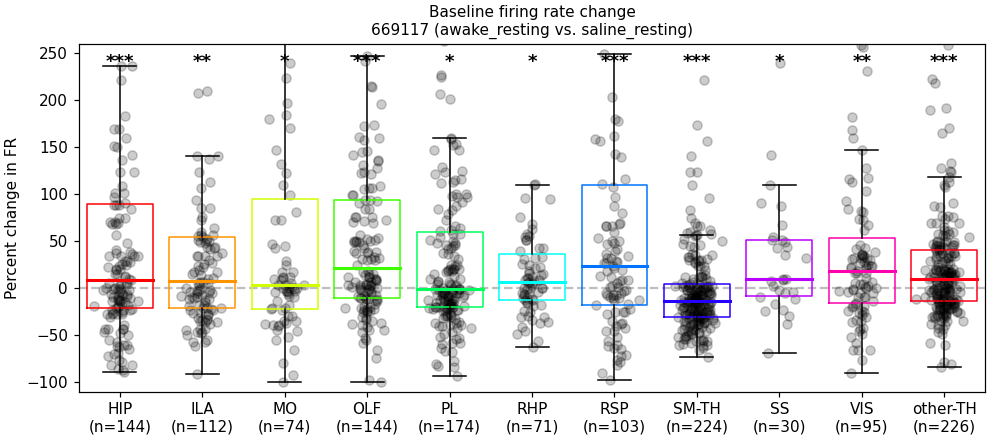

In [21]:
compare_states = ['awake_resting', 'saline_resting']
FRrange = (0, 25)
pbins = FRrange[1] * 2
ylim = 260

all_regions = list(all_subjects_data[mouse][exp_type]['unit_metrics'][compare_states[0]].keys())
acolors = plt.cm.hsv(np.linspace(0, 1, len(all_regions)))

fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)
xlabels = []
pvals = []
ax.axhline(0, color='k', linestyle='dashed', alpha=0.25)
for ii, regi in enumerate(all_regions):
    scatter_vals = []
    for statei in compare_states:
        tempdf = all_subjects_data[mouse][exp_type]['unit_metrics'][statei][regi]
        scatter_vals.append(tempdf['baselineFR'].values)
    scatter_vals = np.stack(scatter_vals)
    scatter_vals = scatter_vals[:, np.nonzero(scatter_vals[0,:])[0]]

#     plot_yvals = scatter_vals[1,:] / scatter_vals[0,:] # simple ratio
    plot_yvals = ((scatter_vals[1,:] - scatter_vals[0,:]) / scatter_vals[0,:]) * 100 # percent increase: ((B-A) / A) * 100

    xs = np.random.normal(ii, 0.1, len(plot_yvals))
    ax.scatter(xs, plot_yvals, c='k', marker='o', alpha=0.2)
    ax.boxplot(
        plot_yvals, positions=[ii], widths=[0.8], showfliers=False,
        medianprops={'color': acolors[ii], 'linewidth': 2}, boxprops={'color': acolors[ii]}
    )
    xlabels.append('{}\n(n={:d})'.format(regi, scatter_vals.shape[1]))
    
    wilc = pg.wilcoxon(plot_yvals)
    pvals.append(wilc['p-val'].values[0])
corr_pvals = pg.multicomp(pvals, method='fdr_bh')
for ii, regi in enumerate(all_regions):
    ax.annotate(
        p_stars(corr_pvals[1][ii]), xy=(ii, ylim-20), xycoords='data',
        fontsize=12, fontweight='bold', ha='center', va='center'
    )

ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels)
ax.set_ylim([-110, ylim])
ax.set_ylabel('Percent change in FR')
ax.set_title('Baseline firing rate change\n{} ({} vs. {})'.format(
    mouse, compare_states[0], compare_states[1]))

## Save ##
figname = '{}_{}_{}_all_units_BLFR.png'.format(mouse, compare_states[0], compare_states[1])
fig.savefig(os.path.join(plotsdir, 'ind_sub_evoked_units', figname), transparent=False, dpi=300)

## Make multi-sub figure

In [18]:
all_states = {
    'awake_resting': 'o', 'awake_running': 'X',
    'psilocybin_resting': 's', 'psilocybin_running': 'P',
    'isoflurane': '^', 'urethane': 'v',
}
stlabels = ['AW\nrest', 'AW\nrun', 'PSI\nrest', 'PSI\nrun', 'ISO', 'UR']

In [18]:
metric_dict = {
    'baselineFR': ['Baseline firing rate', '(Hz)'],
    'fraction_sig': ['Significant response', 'Fraction of pop.'],
    'early_latency': ['First spike latency', 'Time from stim (ms)'],
    'late_latency': ['Rebound spike latency', 'Time from stim (ms)'],
    'burst_prob': ['Burst probability', 'Fraction of trials'],
    'burst_count': ['Burst count', 'Mean evoked\nburst count'],
}

### Plot baseline firing rates

In [75]:
np.unique(all_subs_unit_stats_df['region'].values)

array(['ACA', 'AI', 'FRP', 'HIP', 'ILA', 'MO', 'OLF', 'ORB', 'PAL', 'PL',
       'PTLp', 'RHP', 'RSP', 'RT-TH', 'SM-TH', 'SS', 'STR', 'VIS',
       'other-TH'], dtype=object)

In [100]:
plot_region = 'ILA'
plot_metric = 'baselineFR'

regiondf = all_subs_unit_stats_df[all_subs_unit_stats_df['region'] == plot_region]

In [101]:
for statei in all_states.keys():
    statevals = regiondf[regiondf['state'] == statei][plot_metric].values
    print(statei)
    if len(statevals) > 2:
        swstat, swp = stats.shapiro(statevals)
        if swp < sigalpha:
            normtag = 'NOT normal'
        else:
            normtag = 'normal'
    else:
        normtag = 'cannot run Shapiro-Wilk'
    print(' N={:d}; {}; mean={:.1f}, SEM={:.1f}\n'.format(
        len(statevals), normtag, np.mean(statevals), np.std(statevals)/np.sqrt(len(statevals))
    ))

awake_resting
 N=3; normal; mean=1.5, SEM=0.2

awake_running
 N=3; normal; mean=2.4, SEM=0.3

psilocybin_resting
 N=3; normal; mean=1.8, SEM=0.4

psilocybin_running
 N=3; normal; mean=2.1, SEM=0.5

isoflurane
 N=0; cannot run Shapiro-Wilk; mean=nan, SEM=nan

urethane
 N=3; normal; mean=1.1, SEM=0.2



C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Apply a one-way ANOVA

In [86]:
metricANOVA = pg.anova(data=regiondf, dv=plot_metric, between='state', detailed=True)
print('ANOVA between states p-val = {:.3E}'.format(metricANOVA['p-unc'].values[0]))
if metricANOVA['p-unc'].values[0] < sigalpha:
    print('There is a significant effect of state on {}, now perform posthoc tests.'.format(plot_metric))
    metricposthoc = pg.pairwise_tests(data=regiondf, dv=plot_metric, between='state', padjust='fdr_bh')

ANOVA between states p-val = 3.902E-10
There is a significant effect of state on baselineFR, now perform posthoc tests.


In [87]:
sigdf = metricposthoc[metricposthoc['p-corr'] < sigalpha]
sigdf

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
1,state,awake_resting,isoflurane,False,True,7.862957,19.992495,two-sided,1.524679e-07,0.000002,fdr_bh,5.797e+04,2.892988
4,state,awake_resting,urethane,False,True,6.637128,17.864935,two-sided,3.262201e-06,0.000016,fdr_bh,4794.956,2.520830
5,state,awake_running,isoflurane,False,True,8.542031,14.559693,two-sided,4.747099e-07,0.000004,fdr_bh,2.418e+04,3.867492
8,state,awake_running,urethane,False,True,7.230509,13.960620,two-sided,4.424435e-06,0.000017,fdr_bh,2736.3,3.348397
9,state,isoflurane,psilocybin_resting,False,True,-5.548254,5.729914,two-sided,1.685690e-03,0.003612,fdr_bh,81.399,-3.213892
10,state,isoflurane,psilocybin_running,False,True,-6.245628,5.953591,two-sided,8.042377e-04,0.002413,fdr_bh,258.527,-3.710745
13,state,psilocybin_resting,urethane,False,True,4.560243,6.488982,two-sided,3.158467e-03,0.005922,fdr_bh,21.352,2.596703
14,state,psilocybin_running,urethane,False,True,5.464870,6.572900,two-sided,1.160705e-03,0.002902,fdr_bh,76.862,3.164101


Plot it

<IPython.core.display.Javascript object>


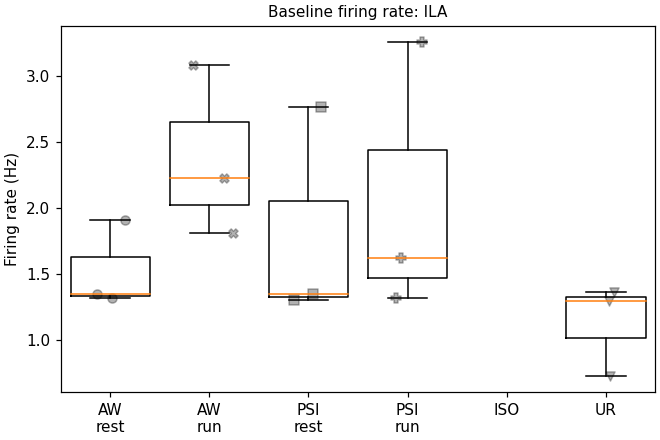

In [102]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

for ii, (statei, stmarker) in enumerate(all_states.items()):
    tempdf = regiondf[regiondf['state'] == statei]
    xs = np.random.normal(ii, 0.1, len(tempdf)) # np.zeros(len(tempdf)) + locs[ii,jj]
    ax.scatter(xs, tempdf[plot_metric].values, c='k', marker=stmarker, alpha=0.3)
    ax.boxplot(
        tempdf[plot_metric].values, positions=[ii], widths=[0.8], showfliers=False,
#         medianprops={'color': rcolor, 'linewidth': 2}, boxprops={'color': rcolor},
    )
ax.set_title('Baseline firing rate: {}'.format(plot_region))
ax.set_ylabel('Firing rate (Hz)')
ax.set_xticklabels(stlabels)

## Add stats ##
# for (indi, sigrow), yval in zip(sigdf.iterrows(), [7, 7.5, 8, 8.5, 9, 10, 9.5, 10.5]):
#     xA = np.nonzero(np.array(list(all_states.keys())) == sigrow.A)[0][0]
#     xB = np.nonzero(np.array(list(all_states.keys())) == sigrow.B)[0][0]
#     ax.plot([xA, xB], [yval, yval], color='k', linewidth=2)
#     ax.annotate(
#         p_stars(sigrow['p-corr']), xy=(np.min([xA, xB]), yval), xycoords='data', # np.min([xA, xB]); (xA + xB)/2
#         fontsize=12, fontweight='bold', ha='left', va='center'
#     )
    
## Save ##
figname = '{}_{}_all_subs_states.png'.format(plot_region, plot_metric)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

Plot all areas